How Temperature Affects Coulomb Counting
a. Battery Capacity Is Temperature-Dependent
Battery capacity 
𝐶
C decreases at low temperatures because:

Electrochemical reactions slow down

Internal resistance increases

Some capacity becomes inaccessible

Example:
A 100Ah battery might only deliver ~80Ah at -10°C.

➡️ Coulomb counting will overestimate SoC at low temps, since it assumes a fixed 100Ah.

b. Current Sensor Drift
Shunt-based or Hall-effect current sensors can drift with temperature, leading to:

Small, systematic errors in current

Which accumulate into significant SoC errors over time

➡️ Thermal compensation is often needed in sensor electronics.

c. Self-Discharge and Parasitic Losses
These increase with temperature:

Coulomb counting doesn't track self-discharge

High temperatures make this worse

➡️ Coulomb counting underestimates SoC at high temps if not corrected.

d. Internal Resistance & Peukert Effect
Though less significant for simple Coulomb counting:

Resistance increases at low T

High internal resistance causes greater power loss

In [1]:
def temperature_corrected_capacity(nominal_capacity, temperature_c):
    """
    Adjust capacity based on temperature.
    Capacity decreases ~0.5% per °C below 25°C.
    """
    if temperature_c < 25:
        reduction_factor = 1 - 0.005 * (25 - temperature_c)
    else:
        reduction_factor = 1  # No gain above 25°C (can be refined)
    return nominal_capacity * reduction_factor


def ah_integration_temp(soc_initial, current, time_step, nominal_capacity, temperature_c):
    """
    Estimate SoC using Ah integration with temperature-corrected capacity.
    soc_initial: Initial SoC (0 to 1)
    current: Current in A (positive for charge, negative for discharge)
    time_step: Time interval in hours
    nominal_capacity: Battery capacity in Ah at 25°C
    temperature_c: Current temperature in °C
    """
    capacity_effective = temperature_corrected_capacity(nominal_capacity, temperature_c)
    charge_change = current * time_step  # Ah
    soc_change = charge_change / capacity_effective
    soc_new = soc_initial + soc_change
    return max(0, min(1, soc_new))  # Clamp SoC between 0 and 1


# Example usage
soc_0 = 0.8          # 80%
current = -5         # 5A discharge
time_step = 2        # 2 hours
capacity = 100       # 100 Ah at 25°C
temperature = 10     # 10°C

soc = ah_integration_temp(soc_0, current, time_step, capacity, temperature)
print(f"New SoC at {temperature}°C: {soc * 100:.1f}%")


New SoC at 10°C: 69.2%


Coulomb counting is straightforward and responsive, but it’s prone to drift over time due to sensor errors, current integration inaccuracies, and environmental factors. To mitigate this drifting effect, several strategies are commonly used in both research and industrial applications:

✅ 1. Periodic Recalibration with OCV (Rest-Based Correction)
During long rest periods (no current), the terminal voltage approximates the Open Circuit Voltage (OCV).

Convert this voltage to SoC using an OCV–SoC curve and recalibrate the Coulomb counting SoC.

This is most effective in stationary applications (e.g. energy storage, EVs during parking).

In [1]:
def temperature_corrected_capacity(nominal_capacity, temperature_c):
    """
    Adjust capacity based on temperature.
    Capacity decreases ~0.5% per °C below 25°C.
    """
    if temperature_c < 25:
        reduction_factor = 1 - 0.005 * (25 - temperature_c)
    else:
        reduction_factor = 1  # No gain above 25°C
    return nominal_capacity * reduction_factor


def ocv_to_soc(ocv):
    """
    Dummy function to map OCV to SoC.
    You should replace this with real battery OCV-SoC curve fitting.
    """
    # Simple linear mapping for example
    ocv_min = 3.0
    ocv_max = 4.2
    return max(0, min(1, (ocv - ocv_min) / (ocv_max - ocv_min)))


def recalibrate_soc(soc_coulomb, ocv, alpha=0.9):
    """
    Blend Coulomb-counted SoC with OCV-based SoC estimate.
    alpha: weight given to Coulomb result (e.g., 0.9 means 90% trust in integration)
    """
    soc_ocv = ocv_to_soc(ocv)
    return alpha * soc_coulomb + (1 - alpha) * soc_ocv


def ah_integration_temp(soc_initial, current, time_step, nominal_capacity, temperature_c, is_rest_period=False, ocv_measured=None):
    """
    Estimate SoC using Ah integration with temperature correction and optional OCV recalibration.
    """
    capacity_effective = temperature_corrected_capacity(nominal_capacity, temperature_c)
    charge_change = current * time_step  # Ah
    soc_change = charge_change / capacity_effective
    soc_new = soc_initial + soc_change
    soc_new = max(0, min(1, soc_new))  # Clamp SoC

    if is_rest_period and ocv_measured is not None:
        # Apply recalibration
        soc_new = recalibrate_soc(soc_new, ocv_measured, alpha=0.9)

    return soc_new


# Example usage
soc_0 = 0.8              # 80%
current = -5             # 5A discharge
time_step = 2            # 2 hours
capacity = 100           # Ah at 25°C
temperature = 10         # °C
ocv_measured = 3.75      # Simulated OCV after rest
is_rest = True           # Rest period flag

soc = ah_integration_temp(soc_0, current, time_step, capacity, temperature, is_rest, ocv_measured)
print(f"New SoC at {temperature}°C after rest: {soc * 100:.1f}%")


New SoC at 10°C after rest: 68.5%


MAPE (Estimated SoC): 1.63%
MAPE (Uncompensated SoC): 5.66%


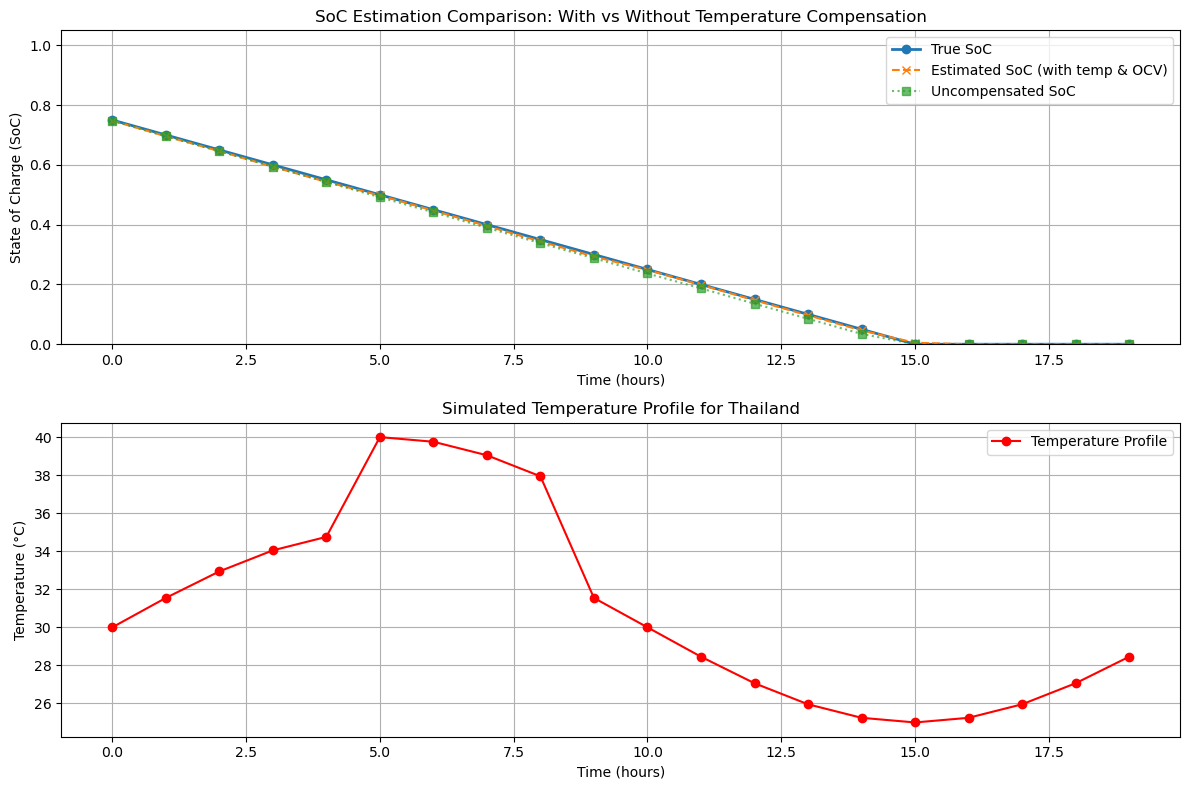

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def temperature_corrected_capacity(nominal_capacity, temperature_c):
    """
    Adjust capacity based on temperature.
    Capacity decreases ~0.5% per °C below 25°C.
    """
    if temperature_c < 25:
        reduction_factor = 1 - 0.005 * (25 - temperature_c)
    else:
        reduction_factor = 1  # No gain above 25°C
    return nominal_capacity * reduction_factor


def ocv_to_soc(ocv):
    """
    Dummy function to map OCV to SoC.
    Replace this with real battery OCV-SoC curve fitting.
    """
    ocv_min = 3.0
    ocv_max = 4.2
    return max(0, min(1, (ocv - ocv_min) / (ocv_max - ocv_min)))


def recalibrate_soc(soc_coulomb, ocv, alpha=0.9):
    """
    Blend Coulomb-counted SoC with OCV-based SoC estimate.
    alpha: weight given to Coulomb result (e.g., 0.9 means 90% trust in integration)
    """
    soc_ocv = ocv_to_soc(ocv)
    return alpha * soc_coulomb + (1 - alpha) * soc_ocv


def ah_integration_temp(soc_initial, current, time_step, nominal_capacity, temperature_c, is_rest_period=False, ocv_measured=None):
    """
    Estimate SoC using Ah integration with temperature correction and optional OCV recalibration.
    """
    capacity_effective = temperature_corrected_capacity(nominal_capacity, temperature_c)
    charge_change = current * time_step  # Ah
    soc_change = charge_change / capacity_effective
    soc_new = soc_initial + soc_change
    soc_new = max(0, min(1, soc_new))  # Clamp SoC

    if is_rest_period and ocv_measured is not None:
        # Apply recalibration
        soc_new = recalibrate_soc(soc_new, ocv_measured, alpha=0.9)

    return soc_new


def ah_integration_uncompensated(soc_initial, current, time_step, nominal_capacity):
    """
    Traditional Coulomb counting without temp compensation or recalibration.
    """
    charge_change = current * time_step
    soc_change = charge_change / nominal_capacity
    soc_new = soc_initial + soc_change
    return max(0, min(1, soc_new))


# Simulation parameters
steps = 20
soc_true = 0.8
soc_est = 0.8
soc_uncomp = 0.8

true_soc_list = []
est_soc_list = []
uncomp_soc_list = []
time_list = []
temperature_profile = []

current = -5          # Discharge current in A
time_step = 1         # Time step in hours
capacity = 100        # Nominal capacity at 25°C
current_bias = 1.02   # 2% bias in current measurement to simulate drift
current_noise_std = 0.1  # Standard deviation of current measurement noise

# Define a realistic high-temperature profile for Thailand
def temperature_profile_function(t):
    """
    Simulate a realistic high-temperature profile for Thailand.
    Example: Baseline at 30°C, small fluctuations (±2°C), and occasional peaks to 35°C.
    """
    baseline = 30  # Typical ambient temperature in Thailand
    fluctuation = 5 * np.sin(2 * np.pi * t / steps)  # Small sinusoidal fluctuations
    peak = 5 if t in [5, 6, 7, 8] else 0  # Occasional peak to 35°C during midday
    return baseline + fluctuation + peak


for t in range(steps):
    # Get the temperature at the current time step
    temperature = temperature_profile_function(t)
    temperature_profile.append(temperature)

    # Effective capacity at the current temperature
    effective_capacity = temperature_corrected_capacity(capacity, temperature)

    # Rest period logic
    is_rest = (t % 5 == 0 and t != 0)  # Rest every 5 steps
    ocv_measured = 3.0 + 1.2 * soc_true if is_rest else None

    # Simulate noisy and biased current measurement
    measured_current = current * current_bias + np.random.normal(0, current_noise_std)

    # Improved estimation with temperature correction and OCV recalibration
    soc_est = ah_integration_temp(soc_est, measured_current, time_step, capacity, temperature, is_rest, ocv_measured)

    # Uncompensated Coulomb counting
    soc_uncomp = ah_integration_uncompensated(soc_uncomp, measured_current, time_step, capacity)

    # Simulated true SoC (affected by temperature)
    soc_true += (current * time_step) / effective_capacity
    soc_true = max(0, min(1, soc_true))

    # Record data
    time_list.append(t)
    true_soc_list.append(soc_true)
    est_soc_list.append(soc_est)
    uncomp_soc_list.append(soc_uncomp)

# Calculate MAPE
def calculate_mape(true_socs, estimated_socs):
    """
    Calculate Mean Absolute Percentage Error (MAPE).
    """
    errors = [
        abs((true_soc - est_soc) / true_soc) * 100
        for true_soc, est_soc in zip(true_socs, estimated_socs)
        if true_soc > 0  # Avoid division by zero
    ]
    return sum(errors) / len(errors) if errors else 0

mape_est = calculate_mape(true_soc_list, est_soc_list)
mape_uncomp = calculate_mape(true_soc_list, uncomp_soc_list)

print(f"MAPE (Estimated SoC): {mape_est:.2f}%")
print(f"MAPE (Uncompensated SoC): {mape_uncomp:.2f}%")

# Plotting
plt.figure(figsize=(12, 8))

# Plot SoC comparison
plt.subplot(2, 1, 1)
plt.plot(time_list, true_soc_list, label="True SoC", marker='o', linewidth=2)
plt.plot(time_list, est_soc_list, label="Estimated SoC (with temp & OCV)", marker='x', linestyle='--')
plt.plot(time_list, uncomp_soc_list, label="Uncompensated SoC", marker='s', linestyle=':', alpha=0.7)
plt.xlabel("Time (hours)")
plt.ylabel("State of Charge (SoC)")
plt.title("SoC Estimation Comparison: With vs Without Temperature Compensation")
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)

# Plot temperature profile
plt.subplot(2, 1, 2)
plt.plot(time_list, temperature_profile, label="Temperature Profile", marker='o', color='red')
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.title("Simulated Temperature Profile for Thailand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()